## Segunda parte: Análisis de los datos e información

In [1]:
import mysql.connector
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import calendar
import requests
import json

In [2]:
db_connection = mysql.connector.connect(
    host="127.0.0.1",
    user="root",
    password="root",
    database="atc"
)

Categorias:

0. Solicitudes de ayuda / contacto urgente
1. Reenvío de facturas
2. Consulta contratos y documentación
3. Problemas con el área de clientes y problemas técnicos
4. Cambios de documentación / titularidad / bajas (cambio papeleos)
5. Reclamaciones y quejas
6. Consultas generales

In [3]:
label_mapping = {
    0: "Solicitudes de ayuda / contacto",
    1: "Reenvío de facturas",
    2: "Consulta contratos y documentación",
    3: "Problemas con el área de clientes y problemas técnicos",
    4: "Cambios de documentación / titularidad / bajas",
    5: "Reclamaciones y quejas",
    6: "Consultas generales"
}

In [4]:
sql_query = "SELECT * FROM emails"

cursor = db_connection.cursor()
cursor.execute(sql_query)
column_names = [desc[0] for desc in cursor.description]
emails_data = cursor.fetchall()
emails_df = pd.DataFrame(emails_data, columns=column_names)

In [7]:
type(emails_df)

pandas.core.frame.DataFrame

In [12]:
#API call with all the data
url = "http://127.0.0.1:5000/predict_category"
headers = {
    "Content-Type": "application/json"
}

y_labels_predicted = []

for _, email in emails_df.iterrows():
    payload = {
        "client_id": email['client_id'],
        "fecha_envio": email['fecha_envio'].strftime('%m/%d/%Y'),
        "email_body": email['email']
    }
    json_payload = json.dumps(payload)
    response = requests.post(url, data=json_payload, headers=headers)
    if response.status_code == 200:
        response_json = response.json()
        if response_json.get("exito"):
            y_labels_predicted.append(response_json["prediccion"])

Request successful!
Response: {'exito': False, 'razon': 'El cliente tiene impagos'}
Request successful!
Response: {'exito': True, 'prediccion': 'Reenvío de facturas'}
Request successful!
Response: {'exito': True, 'prediccion': 'Reenvío de facturas'}
Request successful!
Response: {'exito': True, 'prediccion': 'Reenvío de facturas'}
Request successful!
Response: {'exito': True, 'prediccion': 'Reenvío de facturas'}
Request successful!
Response: {'exito': True, 'prediccion': 'Reenvío de facturas'}
Request successful!
Response: {'exito': True, 'prediccion': 'Reenvío de facturas'}
Request successful!
Response: {'exito': False, 'razon': 'El cliente tiene impagos'}
Request successful!
Response: {'exito': True, 'prediccion': 'Reenvío de facturas'}
Request successful!
Response: {'exito': True, 'prediccion': 'Reenvío de facturas'}
Request successful!
Response: {'exito': True, 'prediccion': 'Reenvío de facturas'}
Request successful!
Response: {'exito': False, 'razon': 'El cliente tiene impagos'}
R

In [11]:
y_labels_predicted

['Reenvío de facturas',
 'Reenvío de facturas',
 'Reenvío de facturas',
 'Reenvío de facturas',
 'Reenvío de facturas',
 'Reenvío de facturas',
 'Reenvío de facturas',
 'Reenvío de facturas',
 'Reenvío de facturas',
 'Reenvío de facturas',
 'Reenvío de facturas',
 'Reenvío de facturas',
 'Reenvío de facturas',
 'Reenvío de facturas',
 'Reenvío de facturas',
 'Reenvío de facturas',
 'Reenvío de facturas']

Como se puede ver, el modelo no puede predecir los emails con gran precisión, ya que clasifica todos con la misma categoría. Se predice que el remitente pide el reenvío de las facturas en todos casos, esto es por qué la gran mayoría de los emails tienen esta categoria, y, al haber pocos emails (23), el modelo escoge siempre la categoría más problable que se repite en la gran mayoría de casos. En caso de que se tubiera un dataset de más importancia, es decir, de mayor tamaño y que hubiera un balanceo razonable de categorias, el modelo DistilBert podría categorizar con un mayor éxito.

Por ello, se realizará un análisis, pero con los emails categorizados manualmente.

In [26]:
y_labels = [
    3, 3, 6, 1, 3, 2, 1, 1, 1, 2, 2, 2, 2, 4, 4, 1, 1, 1, 1, 1, 1, 1, 0
]
emails_df["category"] = y_labels
display(emails_df.head())

,id,fecha_envio,client_id,email,category
0,24,2022-06-12 06:23:15,1,Hola\nSoy cliente pero no puedo acceder a mi f...,3
1,25,2022-08-12 19:15:39,2,"Hola, buenos días. Necesito que alguien me ayu...",3
2,26,2022-05-11 06:26:11,3,Cada cuanto facturas el gas. Llevo con vosotro...,6
3,27,2022-04-15 19:13:26,4,"Buenos días,\nNo consigo ver la siguiente fact...",1
4,28,2022-04-07 19:25:24,5,"\nHola buenas tardes,\nseguimos desde que real...",3


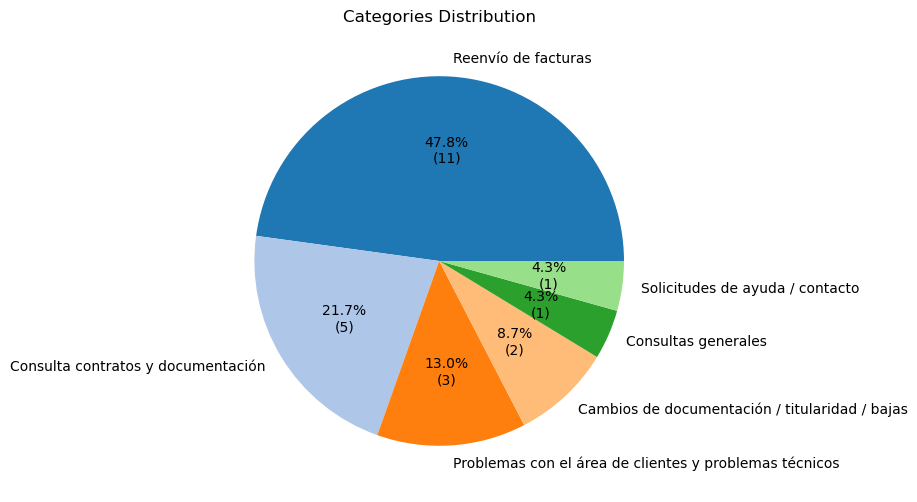

In [41]:
#Categories distribution
def autopct_format(values):
        def my_format(pct):
            total = sum(values)
            val = int(round(pct*total/100.0))
            return '{:.1f}%\n({v:d})'.format(pct, v=val)
        return my_format

plt.figure(figsize=(8, 6))
category_distribution = emails_df['category'].value_counts()
plt.pie(category_distribution, labels=[label_mapping[c] for c in category_distribution.index], autopct=autopct_format(category_distribution), colors=plt.cm.tab20.colors)
plt.title('Categories Distribution')
plt.show()

En este gráfico se puede ver que hay un gran problema con el reenvío de facturas al tener un porcentaje tan elevado de emails de esta categoria (47.8%), por otro lado también suelen haber problemas relacionados con los contratos y documentación, o simplemente se quiere consultar el estado de estos.

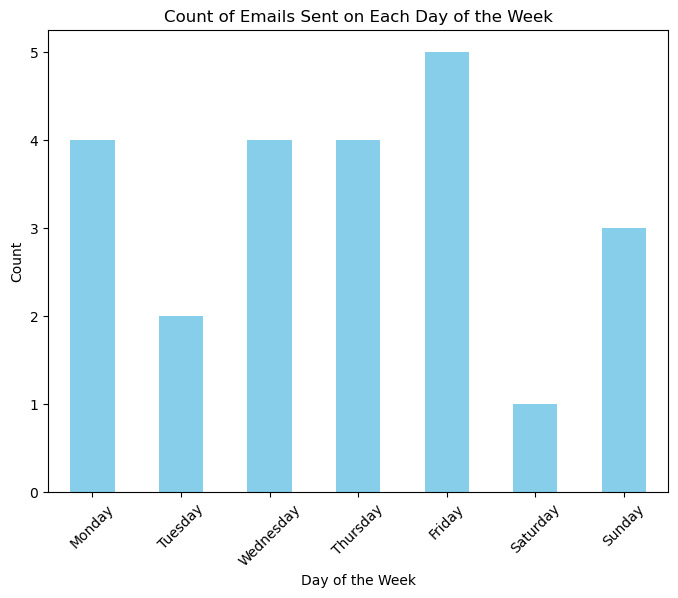

In [55]:
ordered_days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
emails_df['fecha_envio'] = pd.to_datetime(emails_df['fecha_envio'])
emails_df['day_of_week'] = emails_df['fecha_envio'].dt.day_name()

plt.figure(figsize=(8, 6))
emails_df['day_of_week'].value_counts().reindex(ordered_days).plot(kind='bar', color='skyblue')
plt.title('Count of Emails Sent on Each Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

Se puede observar que la gran mayoría de correos se envían en fecha de viernes, domingo y lunes. Esto puede indicar que, primero; se suelen cobrar facturas en esos dias, y segundo; no se envían correctamente las facturas una vez realizado el cobro.

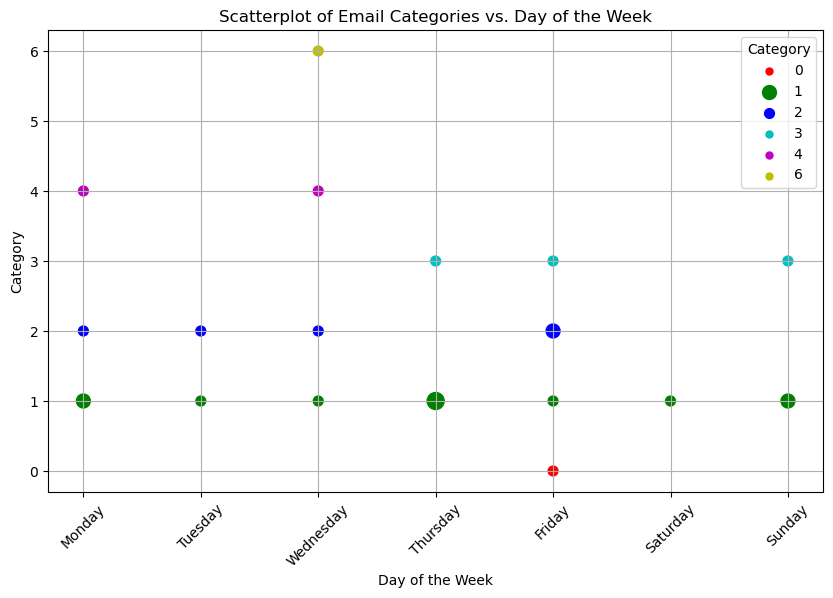

In [65]:
emails_df['day_of_week'] = pd.Categorical(emails_df['day_of_week'], categories=ordered_days, ordered=True)
count_df = emails_df.groupby(['category', 'day_of_week']).size().reset_index(name='count')

plt.figure(figsize=(10, 6))
colors = ['r', 'g', 'b', 'c', 'm', 'y', 'k']
for i, (category, group) in enumerate(count_df.groupby('category')):
    size = [50 * count for count in group['count']]
    plt.scatter(group['day_of_week'], [category] * len(group), label=category, color=colors[i], s=size)

plt.title('Scatterplot of Email Categories vs. Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Category')
plt.legend(title='Category')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

Aquí se puede comprobar la cantidad de emails junto al día de la semana y a su vez con la categoría de emails. 
Podemos pensar que hay gran valor de los datos en las categorias 4, 3 y 2, ya que estos suelen estar ubicados en unos momentos concretos de la semana, por ejemplo, para la categoría 3 habrían problemas relacionados con el área de clientes (problemas técnicos), pero nuevamente, al haber tan pocas muestras no podríamos sacar conclusiones seguras de esto ya que como se ve en el primer grafico, solo existen 3 emails de este tipo.

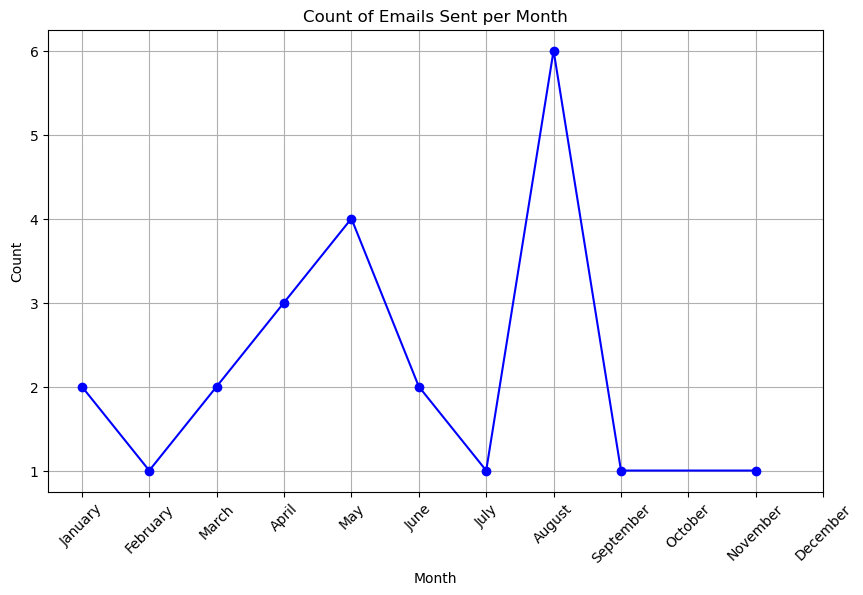

In [67]:
emails_df['month'] = emails_df['fecha_envio'].dt.month
monthly_counts = emails_df['month'].value_counts().sort_index()

plt.figure(figsize=(10, 6))
monthly_counts.plot(kind='line', marker='o', color='b', linestyle='-')
plt.title('Count of Emails Sent per Month')
plt.xlabel('Month')
plt.ylabel('Count')
plt.xticks(range(1, 13), calendar.month_name[1:13], rotation=45)
plt.grid(True)
plt.show()

Finalmente, se ha generado un gráfico de líneas que muestra la cantidad de correos electrónicos por mes durante el año 2022. Se observa un notable aumento en los meses de agosto y mayo. Esta observación es significativa y sugiere la posibilidad de incidencias durante estos meses, ya sea relacionadas con el cobro de facturas o problemas generales.

### Recomendaciones finales:
- Estrategias de asignación de recursos: Considerar asignar más recursos durante los meses de agosto y mayo para abordar posibles incidencias relacionadas con el cobro de facturas y otros problemas generales.

- Formación del equipo de Atención al Cliente: Identificar áreas de formación o capacitación para el equipo de Atención al Cliente en el manejo de consultas sobre contratos y documentación y mejorar sobretodo la eficiencia en el proceso de reenvío de facturas.

- Medidas preventivas: Implementar medidas preventivas para reducir el volumen de ciertas categorías de problemas, como mejorar los procesos de envío de facturas y proporcionar recursos adicionales para la autogestión de clientes en áreas problemáticas, como consultas sobre contratos y documentación.

Finalmente, me gustaría destacar que el análisis revela la necesidad de contar con una mayor cantidad de datos en el dataset para entrenar un modelo de clasificación más robusto. La falta de muestras en algunas categorías, como se observa en el caso de la categoría 3 con solo 3 correos electrónicos, limita la capacidad del modelo para aprender patrones significativos y realizar predicciones precisas.